**Instituto Tecnológico de Aeronáutica – ITA**

**Visão Computacional - CM-203**

**Professores:** 

Arthur Fernandes de Morais

Elcio Hideiti Shiguemori

Gabriel Adriano de Melo

Marcos Ricardo Omena de Albuquerque Maximo

**Orientações padrão:**

Antes de você entregar o Lab, tenha certeza de que tudo está rodando corretamente (sequencialmente): Primeiro, **reinicie o kernel** (`Runtime->Restart Runtime` no Colab ou `Kernel->Restart` no Jupyter), depois rode todas as células (`Runtime->Run All` no Colab ou `Cell->Run All` no Jupyter) e verifique que as células rodem sem erros, principalmente as de correção automática que apresentem os `assert`s.

É muito importante que vocês não apaguem as células de resposta para preenchimento, isto é, as que contenham o `ESCREVA SEU CÓDIGO AQUI` ou o "ESCREVA SUA RESPOSTA AQUI", além das células dos `assert`, pois elas contém metadados com o id da célula para os sistemas de correção automatizada e manual. O sistema de correção automatizada executa todo o código do notebook, adicionando testes extras nas células de teste. Não tem problema vocês criarem mais células, mas não apaguem as células de correção. Mantenham a solução dentro do espaço determinado, por organização. Se por acidente acontecer de apagarem alguma célula que deveria ter a resposta, recomendo iniciar de outro notebook (ou dar um `Undo` se possível), pois não adianta recriar a célula porque perdeu o ID.

Os Notebooks foram programados para serem compatíveis com o Google Colab, instalando as dependências necessárias automaticamente a baixando os datasets necessários a cada Lab. Os comandos que se inicial por ! (ponto de exclamação) são de bash e também podem ser executados no terminal linux, que justamente instalam as dependências.

---------------

In [ ]:
# Se for executar localmente, tenha as seguintes bibliotecas instaladas
# !pip install fastai==2.7.9 pandas

from fastai.vision.all import *
from fastai.basics import *
from fastai.data.transforms import RandomSplitter
import torch
import numpy as np
import pandas as pd
from torch import nn

torch.manual_seed(442)
np.random.seed(442)
plt.rc('figure', dpi=90)

In [ ]:
def custom_set_seed(dls,x=442):
    random.seed(x)
    dls.rng.seed(x) 
    np.random.seed(x)
    torch.manual_seed(x)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(x)

In [ ]:
path_mnist_sample = untar_data(URLs.MNIST_SAMPLE)

In [ ]:
path_mnist_sample

Path('/root/.fastai/data/mnist_sample')

------------------

## Paralelo entre visão computacional e cortex visual

Estudos de David H. Hubel e Torsten Wiesel sobre córtex visual inspiraram, entre as décadas de 80 e 90, o desenvolvimento do que hoje chamamos de Redes Neurais Convolucionais. 

Os estudos desses pesquisadores concluíram que o funcionamento do cortex visual de alguns seres vivos contém receptores neurais responsáveis por captar padrões simples de imagens, e que aparentemente, os cérebros desses seres vivos, ao formar images com padrões complexos, se valem de uma combinação de conexões entre esses receptores mais simples.

https://braintour.harvard.edu/archives/portfolio-items/hubel-and-wiesel

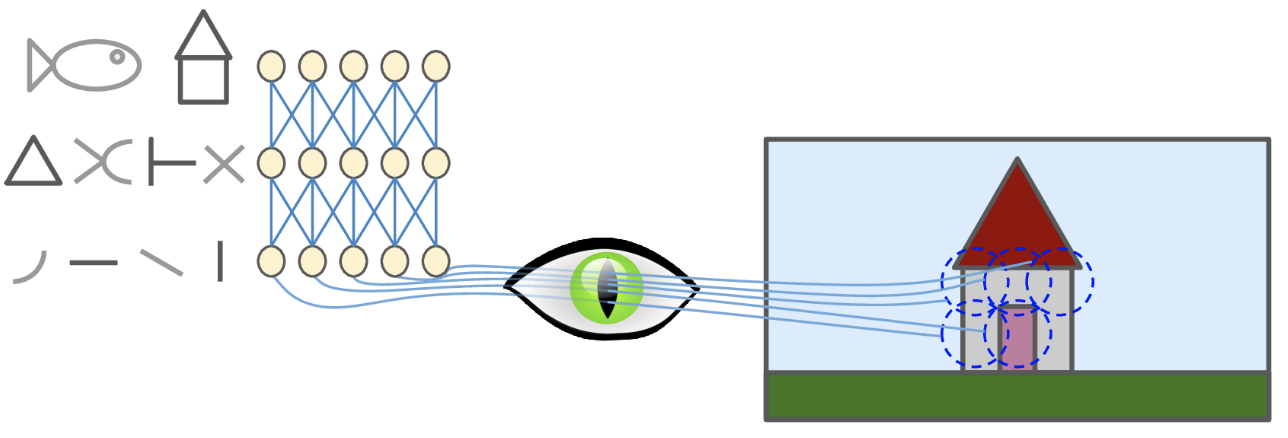

Influenciados pelas ideias desses pesquisadores, mas no contexto de inteligência artificial, um marco importante foi um artigo de 1985 de Yann LeCun, Léon Bottou, Yoshua Bengio e Patrick Haffner, que introduziu a famosa arquitetura LeNet-5, amplamente utilizada para reconhecer números manuscritos. 

Duas ideias apresentadas nesse paper são muito importantes para a compreensão do funcionamento das redes neurais: As operações de convolução e de pooling.

http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf

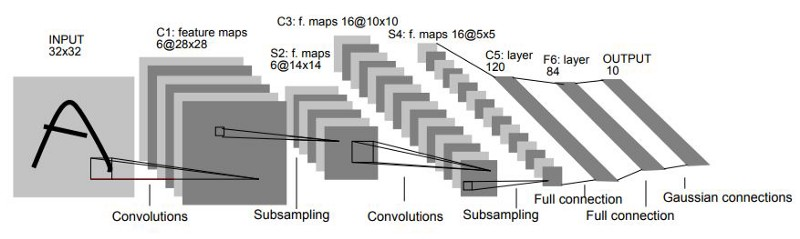

## Convoluções

A ideia central de uma operação de convolução é captar padrões locais nas imagens.

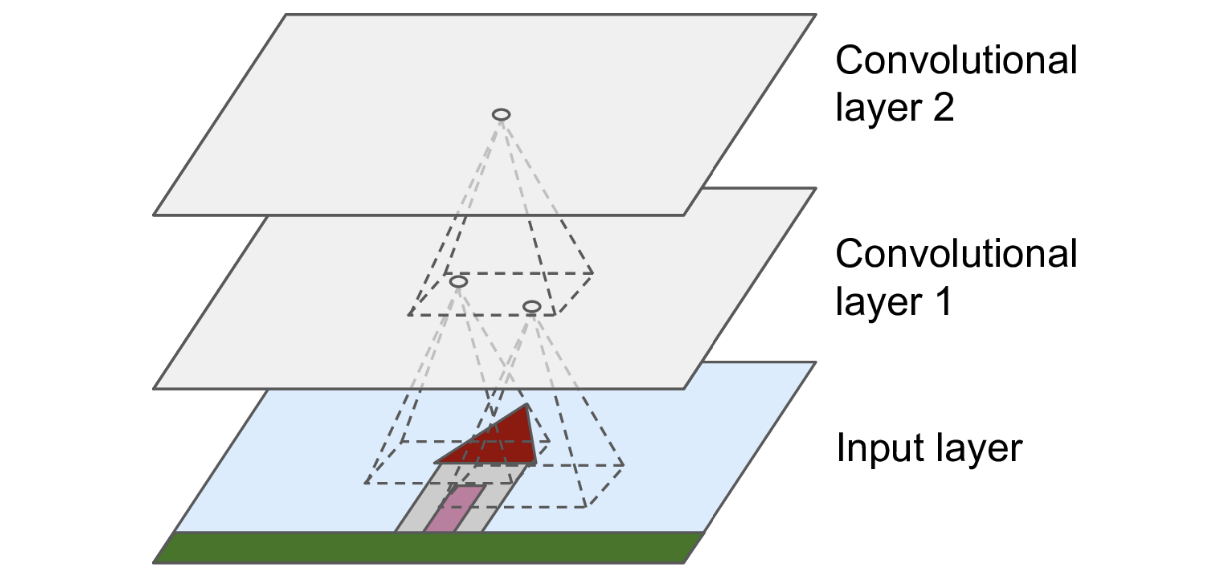

No contexto de visão computacional, queremos destacar features capazes de captar padrões que possam ser utilizados para distinguir uma dada imagem. 

De modo geral, queremos ser capazes de aplicar filtros sobre as imagens (também chamados de kernels) para obtermos outras imagens com as features mapeadas por esses filtros (também chamadas de feature maps).

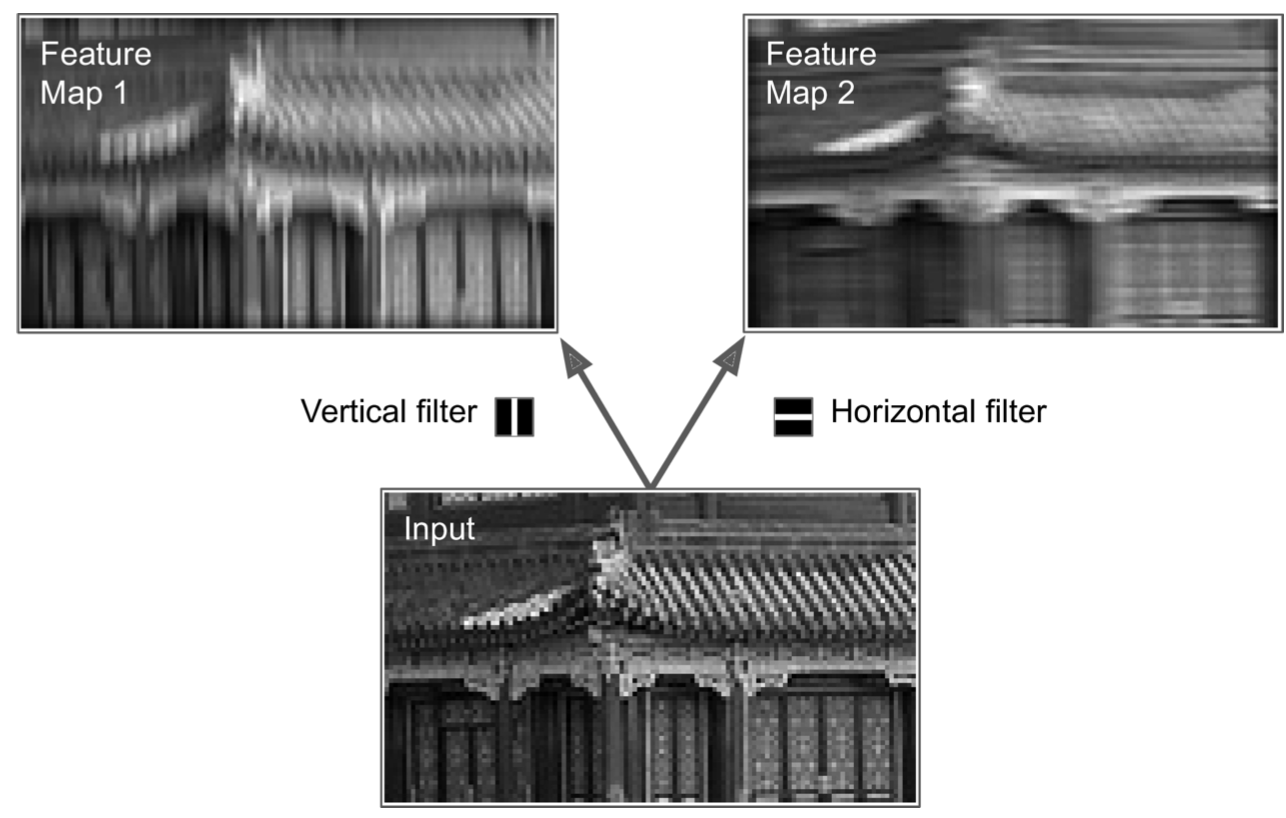

**Exercício:** Complete a implementação da função ```apply_conv_filter``` para aplicar sobre uma imagem (tensor de n linhas e n colunas: variável ```im3_t```) um dado kernel como destacado no diagrama abaixo (tensor de 3 linhas e 3 colunas: ```filter_1``` ou ```filter_2```).

Ou seja, se a imagem original tiver dimensão 4x4, a função deve aplicar o filtro de convolução 3x3 e resultar em uma imagem com dimensão 2x2.

Opcionalmente utilize a função dada ```apply_kernel()``` que realiza uma única operação de multiplicação entre as matrizes Kernel e uma matriz formada por um subconjunto da matriz a qual vai ser aplicada a convolução.

Dica: [Utilize list comprehension](https://www.w3schools.com/python/python_lists_comprehension.asp)

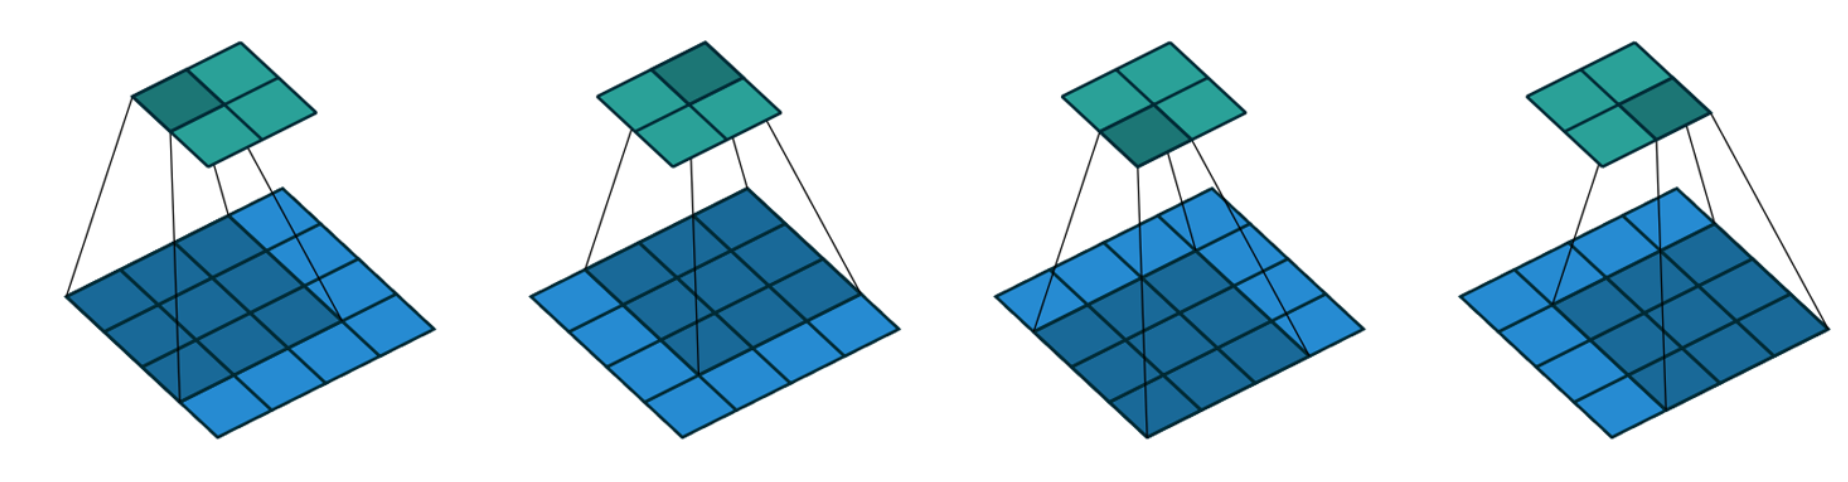

In [ ]:
filter_1 = tensor([[1,1,1 ],
                     [0,0 ,0 ],
                     [-1 ,-1 ,-1 ]]).float()
filter_2 = tensor([[1,0,-1 ],
                    [2,0,-2 ],
                    [1,0,-1 ]]).float()

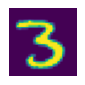

In [ ]:
im3 = Image.open(path_mnist_sample/'train'/'3'/'12.png')
im3_t = tensor(im3)
show_image(im3_t)

In [ ]:
def apply_kernel(row: int, col: int, kernel: torch.Tensor, image: torch.Tensor) -> torch.Tensor:
    """
    Aplica um kernel em uma dada região de uma imagem
    para uma operação de convolução com padding=0 e stride=1

    Args:
        row (int): Índice da linha correspondente ao ponto central do kernel
        na região da imagem a ser aplicada a convolução
        col (int): Índice da coluna correspondente ao ponto central do kernel
        na região da imagem a ser aplicada a convolução
        kernel (tensor): Filtro convolucional a ser aplicado na imagem
        image (tensor): Imgem a qual será aplicada o filtro convolucional

    Returns:
        torch.Tensor: Tensor correspondente a imagem depois de sofrer uma
        operação de convolução a partir do kernel.
    """
    return (image[row-1:row+2,col-1:col+2] * kernel).sum()

In [79]:
def apply_conv_filter(conv_filter: torch.Tensor, original_image: torch.Tensor) -> torch.Tensor:
    """
    Aplica um filtro de convolução em uma imagem

    Args:
        conv_filter (torch.Tensor): Filtro de convolução
        original_image (torch.Tensor): Imagem original

    Returns:
        torch.Tensor: Tensor correspondente a imagem após ter sido aplicada um foltro de
        convolução sobre ela
    """
    result = tensor(np.zeros((original_image.shape[0]-2,original_image.shape[1]-2), dtype=float))
    for i in range(original_image.shape[0]-2):
      for j in range(original_image.shape[0]-2):
          result[i,j] = apply_kernel(i+1,j+1,conv_filter,original_image)
    return result

In [81]:
result_conv_1 = apply_conv_filter(filter_1, im3_t)
result_conv_2 = apply_conv_filter(filter_2, im3_t)

In [82]:
assert int(result_conv_1[10][10]) == -553
assert int(result_conv_2[10][10]) == -522

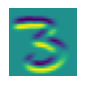

In [83]:
show_image(result_conv_1)

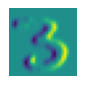

In [84]:
show_image(result_conv_2)

Perceba as diferentes áreas destacadas ao comparar as imagens ```result_conv_1``` e ```result_conv_2```

A ideia dos filtros de convolução durante o treinamento das redes neurais é que consigamos definir quais são os melhores filtros (compostos por pesos a serem aprendidos) para destacar as features mais relevantes nas imagens. Perceba que os filtros de convoluçõ são compostos por pesos a serem aprendidos durante o treinamento.

Para definiir essas camadas de convolução com esses pesos a serem aprendidos durante o processo de treinamento podemos utilizar abtrações do PyTorch como a classe Conv2d

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

**Exercício:** Com base na documentação da classe Conv2d do Pytorch, e a partir dos conceitos de padding e stride apresentados em aula, complete a implementação da função ```conv_layer``` abaixo. Essa função deve retornar uma camada de convolução a ser adicionada posteriormente em uma rede neural.

Considere:
- stride = 2
- padding = ks // 2

In [ ]:
def conv_layer(in_channels: int, out_channels: int, kernel_size: int) -> torch.nn.Conv2d:
    """
    Declara, atribui e retorna uma camada de convolução com stride e padding fixos.

    Args:
        in_channels (int): Número de canais na imagem de entrada
        out_channels (int): Número de canais produzidos pela convolução
        kernel_size (int): Tamanho do kernel convolutivo

    Returns:
        torch.nn.Conv2d: Camada de convolução.
    """
    res = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=kernel_size//2)
    return res

Podemos concatenar sequencialmente as camadas de nossa rede neural convolucional utilizando o método Sequential

https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html

In [ ]:
simple_cnn_1 = sequential(
        conv_layer(in_channels=1, out_channels=4, kernel_size=3),
        nn.ReLU(inplace=False),
        conv_layer(in_channels=4 ,out_channels=8, kernel_size=3), 
        nn.ReLU(inplace=False),
        conv_layer(in_channels=8,out_channels=2, kernel_size=3),
        Flatten()
    )

Conssidere mais uma vez o conjunto de dados do MIST e a célula abaixo que já implementa um ```DataLoaders``` a partir desses dados:

In [ ]:
mnist_sample = DataBlock(
        (ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter(),
        get_y=parent_label
    )
dls = mnist_sample.dataloaders(path_mnist_sample)

**Exercício:** Complete a implementação da função ```construct_learner``` abaixo. 

Essa função deve construir um Learner a partir de um DataLoader considerando a função de loss como a função da entropia cruzada e se utilizar da acurácia como métrica.


https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html#torch.nn.functional.cross_entropy

https://docs.fast.ai/learner.html#learner

In [30]:
def construct_learner(data_loader: DataLoaders, cnn:torch.nn.modules.container.Sequential) -> Learner:
    """
    Constroe um Learner utilizando como função de perda a entropia cruzada e acurácia como métrica
    para o aprendizado da rede neural

    Args:
        data_loader (DataLoaders): DataLoader previamente configurado de acordo com os dados
        necessários para o treinamento da rede
        cnn (torch.nn.modules.container.Sequential): Rede neural com arquitetura previamente definida

    Returns:
        Learner: Learner que será utilizado para o treinamento da rede neural.
    """
    loss = torch.nn.functional.cross_entropy
    learn = Learner(dls = data_loader, model = cnn, metrics=accuracy,loss_func=loss)
    return learn

In [31]:
learn_1 = construct_learner(dls, simple_cnn_1)
learn_1.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 2 x 4 x 4      
Conv2d                                    146        True      
____________________________________________________________________________
                     64 x 32             
Flatten                                                        
____________________________________________________________________________

Total params: 482
Total trainabl

In [32]:
learn_1.fit_one_cycle(5, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.790609,0.405744,0.871443,00:17
1,0.360888,0.357069,0.892542,00:13
2,0.349925,0.344760,0.889598,00:13
3,0.339430,0.337166,0.892542,00:13
4,0.329676,0.336803,0.894014,00:13


## Pooling

Além das operações de convoluções, uma outra operação que está presente em várias arquiteturas clássicas de redes neurais é a de pooling.

Por exemplo considere os diagramas abaixo que apresentam tanto o max pooling quanto o average pooling

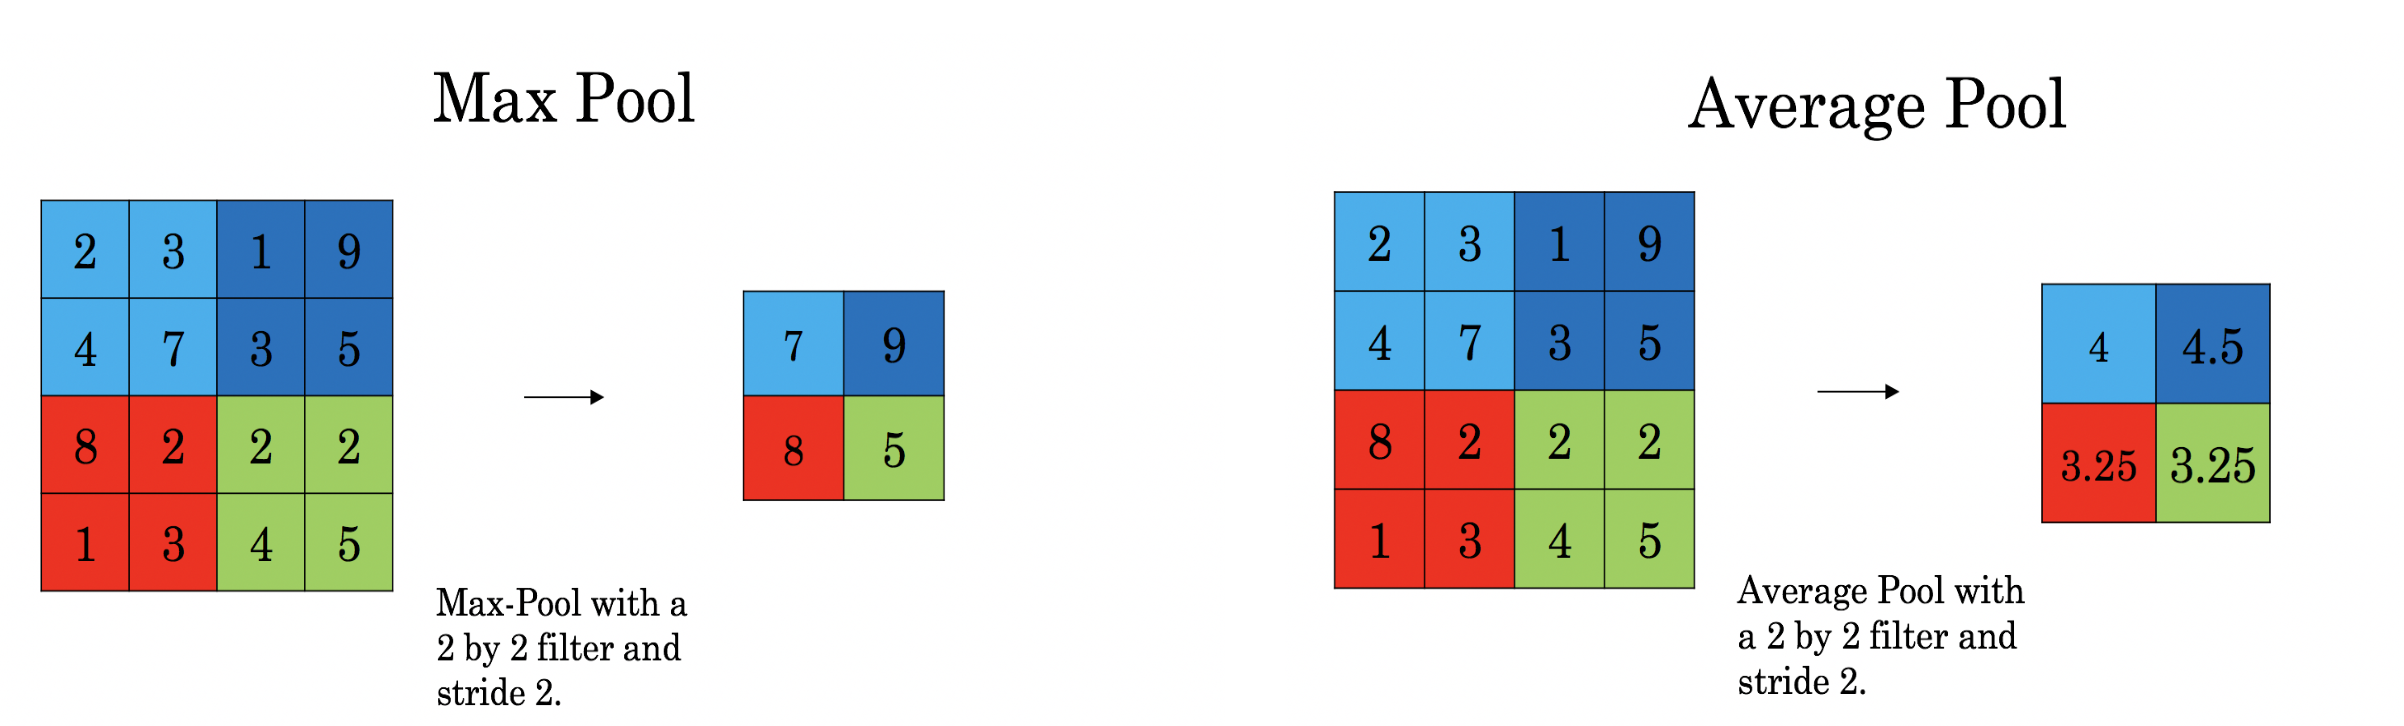

Assim como o principal objetivo das operações de convolução é destacar features relevantes em cada imagem, a intuição em volta da operação de pooling é que a rede neural, ao final do treinamento, adquira uma certa invariância com relação a pequenas translações de imagens distintas, que na maioria dos casos não deveria influenciar na tomada de decisão do modelo.

Por exemplo, perceba os resultados de uma operação de max pooling (stride=2 e kernel=2x2) como descrita no diagrama abaixo.

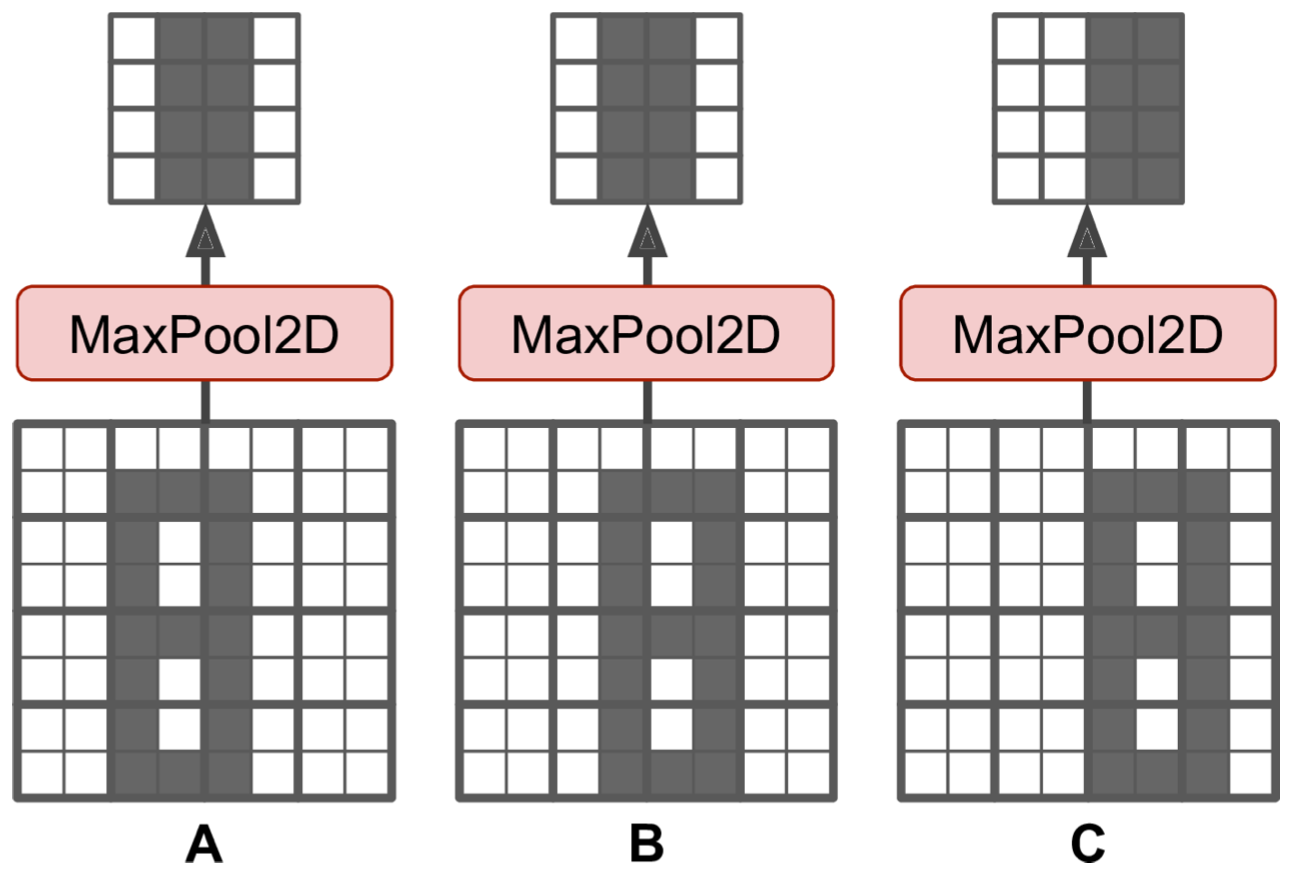

**Exercício**: Analogamente à função já implementada ```apply_kernel``` implemente a função ```max_pool``` que deve aplicar uma operação de max pooling 2d. Considere:
- kernel = 3x3
- stride = 1
- padding = 0

In [59]:
def max_pool(row:int, col:int, image:torch.Tensor) -> torch.Tensor:
    """
    Aplica uma operação de max pooling em uma dada região de uma imagem com centro (row, col)
    com kernel, stride e padding fixos.

    Args:
        row (int): Índice da linha correspondente ao ponto central do kernel
        na região da imagem a ser aplicada a operação de max pooling
        col (int): Índice da coluna correspondente ao ponto central do kernel
        na região da imagem a ser aplicada a operação de max pooling
        image (torch.Tensor): Imgem a qual será aplicada a operação de max pooling

    Returns:
        torch.Tensor: Tensor correspondente a imagem depois de sofrer uma
        operação de max pooling
    """
    result = torch.max(torch.max(image[row-1:row+2,col-1:col+2],axis=0).values)
    return result

Exercício: Utilizando a função max_pool, complete a implementação da função ```apply_max_pooling``` que analogamente à função ```apply_conv_filter``` deve aplicar uma operação de max pooling em uma dada imagem (tensor)

In [73]:
def apply_max_pooling(original_image: tensor) -> tensor:
    result = tensor(np.zeros((original_image.shape[0]-2,original_image.shape[1]-2), dtype=float))
    for i in range(original_image.shape[0]-2):
      for j in range(original_image.shape[0]-2):
          result[i,j] = max_pool(i+1, j+1, original_image)
    return result

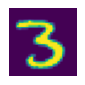

In [74]:
im3 = Image.open(path_mnist_sample/'train'/'3'/'12.png')
im3_t = tensor(im3)
show_image(im3_t)

In [75]:
result_max_pooling = apply_max_pooling(im3_t)

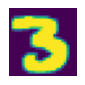

In [76]:
show_image(result_max_pooling)

In [77]:
assert int(result_max_pooling[10][10]) == 254
assert result_max_pooling.shape[0] == 26

De forma similar ao caso apresentado das operações de convolução, o pytorch contém uma classe que facilita a implementação das operações de pooling

**Exercício:** Complete a função ```max_pool_layer``` abaixo, que se utilizando da classe MaxPool2d do pytotrch retorna uma camada de MaxPool2d para ser adicionada a uma rede neural convolucional.

https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d

In [85]:
def max_pool_layer(kernel_size:int, stride:int, padding:int) -> torch.nn.MaxPool2d:
    """
    Declara, atribui e retorna uma camada de max pooling.

    Args:
        kernel_size (int): Dimensão do kernel de tamanho (kernel_size x kernel_size)
        stride (int): Stride da janela do max pooling
        padding (int): Padding da janela do max pooling

    Returns:
        torch.nn.MaxPool2d: Camada de max pooling
    """
    result = torch.nn.MaxPool2d(kernel_size, stride=stride, padding=padding)
    return result

In [86]:
simple_cnn_2 = sequential(
        conv_layer(1, 4, 3),
        nn.ReLU(inplace=False),
        max_pool_layer(3, 1, 0),
        conv_layer(4, 8, 3), 
        nn.ReLU(inplace=False),
        max_pool_layer(3, 1, 0),
        conv_layer(8, 2, 3),
        Flatten()
    )

In [87]:
learn_2 = construct_learner(dls, simple_cnn_2)
learn_2.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 4 x 12 x 12    
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 8 x 6 x 6      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 4 x 4      
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 2 x 2 x

Perceba que essa rede tem o mesmo número de parâmetros da rede anterior. A operação de pooling não adiciona pesos à rede para serem aprendidos durante o processo de treinamento.

In [88]:
learn_2.fit_one_cycle(5, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.374656,0.201233,0.923945,00:14
1,0.130410,0.136739,0.951423,00:16
2,0.111998,0.134494,0.952895,00:15
3,0.099620,0.112112,0.961236,00:15
4,0.083689,0.111304,0.962218,00:14


**Exercício:** Complete a implementação da função ```build_cnn```. 

Essa função deve implementar uma CNN de forma análoga a ```simple_cnn_1``` e ```simple_cnn_2``` já apresentadas. 

A arquitetura da rede neural deve ser definida de acordo com o summary abaixo, ou seja, a rede deve ter exatamente as camadas descritas e consequentemente o mesmo número de parâmetros a serem treinados. 

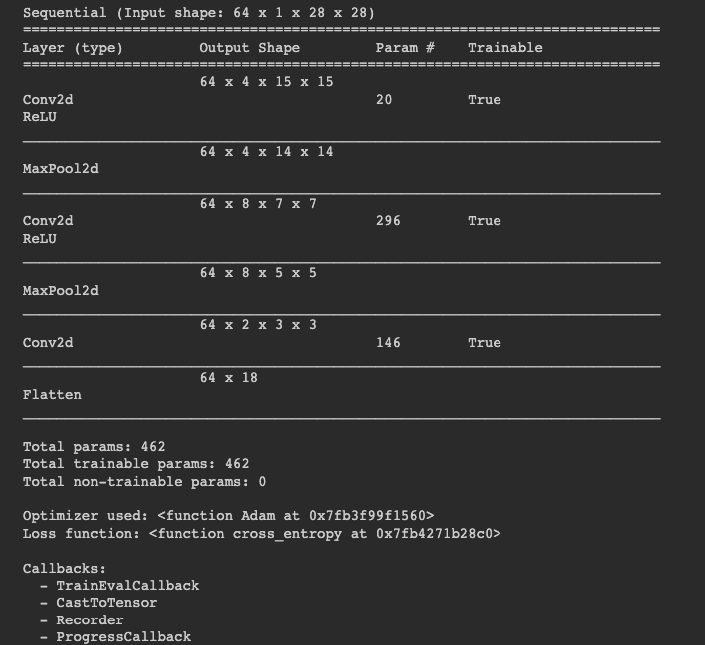

In [89]:
mnist_sample = DataBlock(
        (ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter(),
        get_y=parent_label
    )
path_mnist_sample = untar_data(URLs.MNIST_SAMPLE)
dls = mnist_sample.dataloaders(path_mnist_sample)

In [131]:
def build_cnn() -> nn.Sequential:
    """
    Declara, atribui e retorna uma rede neural convolucional concatenando
    camadas
    Returns:
        nn.Sequential: Rede neural convolucional
    """
    result = nn.Sequential(
        conv_layer(1, 4, 2),
        nn.ReLU(inplace=False),
        max_pool_layer(2, 1, 0),
        conv_layer(4, 8, 3), 
        nn.ReLU(inplace=False),
        max_pool_layer(3, 1, 0),
        conv_layer(8, 2, 3),
        Flatten()
        )
    return result

In [132]:
learn_3 = construct_learner(dls, build_cnn())
learn_3.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 15 x 15    
Conv2d                                    20         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 4 x 14 x 14    
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 5 x 5      
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 2 x 3 x

In [133]:
learn_3.fit_one_cycle(5, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.591926,0.234239,0.915604,00:15
1,0.153417,0.137501,0.957311,00:14
2,0.123599,0.121249,0.960255,00:13
3,0.111749,0.120118,0.961727,00:14
4,0.111053,0.116084,0.961236,00:15
